In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

In [4]:
#!pip install matplotlib wordcloud

### Reading ANIMELIST.CSV

In [5]:
import os

In [6]:
INPUT_DIR = os.path.join("..", "artifacts", "raw")

In [7]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv", low_memory=True, usecols=["user_id","anime_id","rating"])
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [9]:
print(len(rating_df))
print(rating_df.shape)

5000000
(5000000, 3)


### Data Processing

In [12]:
n_ratings = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >= 400].index)].copy()

In [13]:
len(rating_df)

3246641

In [23]:
min_rating = min(rating_df['rating'])
min_rating

0.0

In [24]:
max_rating = max(rating_df['rating'])
max_rating

1.0

In [25]:
avg_rating = np.mean(rating_df['rating'])
avg_rating

np.float64(0.4122732695114729)

In [22]:
rating_df['rating'] = rating_df['rating'].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [28]:
rating_df.duplicated().sum()

np.int64(0)

In [29]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [34]:
user_ids = rating_df['user_id'].unique().tolist()
user2user_encoded = {x : i for i , x in enumerate(user_ids)} # Encoding the users IDs 11056 ---> 98 (user2user_encoded)
user2user_decoded = {i : x for i , x in enumerate(user_ids)} # Decoding the users IDs 98 ---> 11056 (user2user_decoded)
rating_df['user'] = rating_df['user_id'].map(user2user_encoded)

In [38]:
n_users = len(user2user_encoded)
n_users

4203

In [35]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [36]:
anime_ids = rating_df['anime_id'].unique().tolist()
anime2anime_encoded = {x : i for i , x in enumerate(anime_ids)} # Encoding the anime IDs 11056 ---> 98 (anime2anime_encoded)
anime2anime_decoded = {i : x for i , x in enumerate(anime_ids)} # Decoding the anime IDs 98 ---> 11056 (anime2anime_decoded)
rating_df['anime'] = rating_df['anime_id'].map(anime2anime_encoded)

In [37]:
n_anime = len(anime2anime_encoded)
n_anime

17149

In [40]:
rating_df = rating_df.sample(frac=1, random_state=43).reset_index(drop=True)
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,3311,6987,0.0,817,84
1,14146,15883,0.0,3613,1312


In [41]:
X = rating_df[['user','anime']].values
y = rating_df['rating']

In [42]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [43]:
X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [44]:
print(len(X_train))
print(len(X_test))

3245641
1000


In [45]:
print(type(X_train))
print(type(X_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [46]:
X_train_array = [X_train[:,0], X_train[:,1]]
X_test_array = [X_test[:,0], X_test[:,1]]

In [48]:
print(type(X_train_array[0]))
print(type(X_train_array))

<class 'numpy.ndarray'>
<class 'list'>


### Model Architecture

In [49]:
def RecommenderNet():
    embedding_size = 128

    user = Input(name = 'user', shape = [1])

    user_embedding = Embedding(name = "user_embedding", input_dim=n_users, output_dim = embedding_size)(user)

    anime = Input(name = 'anime', shape = [1])

    anime_embedding = Embedding(name = "anime_embedding", input_dim=n_anime, output_dim = embedding_size)(anime)

    x = Dot(name = "dot_product", normalize=True, axes = 2)([user_embedding, anime_embedding])

    x = Flatten()(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user, anime], outputs = x)
    model.compile(loss = "binary_crossentropy", metrics = ["mae","mse"], optimizer = "Adam")

    return model


In [52]:
model = RecommenderNet()

In [53]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [ ]:
# Find the best Learning rate for our model (Copied from stackoverflow)
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8
def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch <ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay **(epoch-ramup_epochs-sustain_epochs) + min_lr

In [56]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch), verbose=0 )
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor="val_loss", mode = "min", save_best_only=True)

early_stopping = EarlyStopping(patience=3, monitor="val_loss", mode = "min", restore_best_weights=True)

In [57]:
my_callbacks = [model_checkpoint, lr_callback, early_stopping]

In [58]:
history = model.fit(
    x=X_train_array, 
    y = y_train,
    batch_size= batch_size,
    epochs = 20,
    verbose=1,
    validation_data = (X_test_array, y_test),
    callbacks = my_callbacks
    )

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.7996 - mae: 0.3820 - mse: 0.1971 - val_loss: 0.7258 - val_mae: 0.3647 - val_mse: 0.1687 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.7964 - mae: 0.3807 - mse: 0.1957 - val_loss: 0.7870 - val_mae: 0.3761 - val_mse: 0.1912 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.7907 - mae: 0.3785 - mse: 0.1934 - val_loss: 0.7918 - val_mae: 0.3770 - val_mse: 0.1926 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.7821 - mae: 0.3752 - mse: 0.1900 - val_loss: 0.7888 - val_mae: 0.3763 - val_mse: 0.1915 - learning_rate: 3.4000e-05


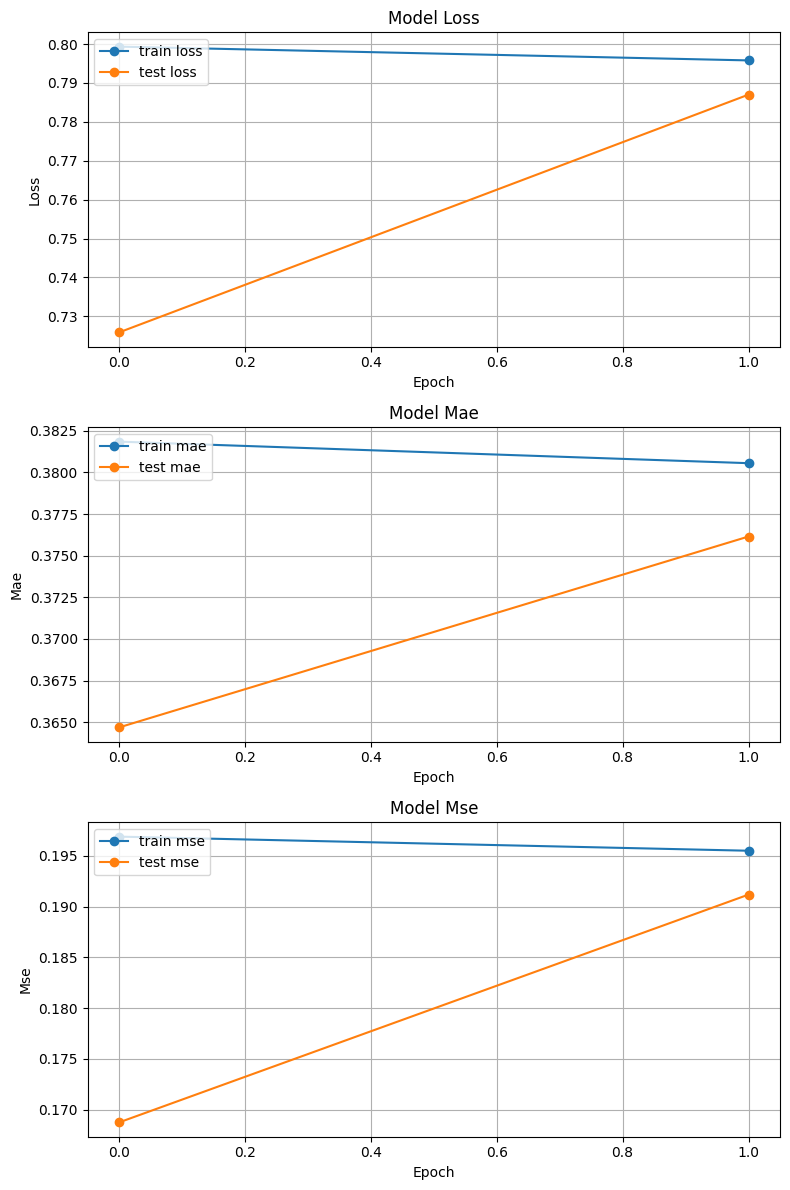

In [59]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [98]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights, axis=1).reshape((-1,1))
    return weights

In [99]:
anime_weights = extract_weights("anime_embedding", model)
user_weights = extract_weights("user_embedding", model)

### Reading Anime.csv

In [100]:
df = pd.read_csv(INPUT_DIR+"/anime.csv", low_memory=True, )
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [101]:
df = df.replace("Unknown", np.nan)

In [102]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]

    except:
        print("Error")

    return name

In [103]:
df['anime_id'] = df['MAL_ID']
df['eng_version'] = df['English name']
df['eng_version'] = df.anime_id.apply(lambda x: getAnimeName(x))

In [104]:
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie


In [105]:
getAnimeName(6702)

'Fairy Tail'

In [106]:
df.sort_values(by = ["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")

In [107]:
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,"Aniplex, Square Enix, Mainichi Broadcasting System, Studio Moriken","Funimation, Aniplex of America",Bones,Manga,24 min. per ep.,R - 17+ (violence & profanity),1.0,3,2248456,183914,171871,1644938,75728,32456,323463,714811.0,401507.0,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,"Production I.G, Dentsu, Mainichi Broadcasting System, Pony Canyon, Kodansha, Techno Sound, Pony Canyon Enterprise",Funimation,MAPPA,Manga,23 min. per ep.,R - 17+ (violence & profanity),2.0,119,733260,44862,566239,553,6658,2090,157720,173154.0,63756.0,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season


In [108]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [109]:
df = df[['anime_id','eng_version','Score','Genres','Episodes','Type', 'Premiered','Members']]
df.head()


,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",51,TV,Spring 2015,404121


In [110]:
def getAnimeFrame(anime, df):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]

In [111]:
getAnimeFrame(40028,df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260


In [112]:
getAnimeFrame("Steins;Gate",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


### Work with ANime_with_synopsis.csv


In [113]:
cols = ['MAL_ID','Name', 'Genres','sypnopsis']

In [114]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv", usecols=cols)
synopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of the often unlucky crew of the Bebop. However, this routine is interrupted when Faye, who is chasing a fairly worthless target on Mars, witnesses an oil tanker suddenly explode, causing mass hysteria. As casualties mount due to a strange disease spreading through the smoke from the blast, a whopping three hundred million woolong price is placed on the head of the supposed perpetrator. With lives at stake and a solution to their money problems in sight, the Bebop crew springs into action. Spike, Jet, Faye, and Edward, followed closely by Ein, split up to pursue different leads across Alba City. Through their individual investigations, they discover a cover-up scheme involving a pharmaceutical company, revealing a plot that reaches much further than the ragtag team of bounty hunters could have realized."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,000,000 bounty on his head. The reason: he's a merciless villain who lays waste to all those that oppose him and flattens entire cities for fun, garnering him the title ""The Humanoid Typhoon."" He leaves a trail of death and destruction wherever he goes, and anyone can count themselves dead if they so much as make eye contact—or so the rumors say. In actuality, Vash is a huge softie who claims to have never taken a life and avoids violence at all costs. With his crazy doughnut obsession and buffoonish attitude in tow, Vash traverses the wasteland of the planet Gunsmoke, all the while followed by two insurance agents, Meryl Stryfe and Milly Thompson, who attempt to minimize his impact on the public. But soon, their misadventures evolve into life-or-death situations as a group of legendary assassins are summoned to bring about suffering to the trio. Vash's agonizing past will be unraveled and his morality and principles pushed to the breaking point."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, Magic","ches are individuals with special powers like ESP, telekinesis, mind control, etc. Robin, a 15-year-old craft user, arrives from Italy to Japan to work for an organization named STN Japan Division (STN-J) as a replacement for one of STN-J's witch hunters who was recently killed. Unlike other divisions of STN, STN-J tries to capture the witches alive in order to learn why and how they became witches in the first place. (Source: ANN)"
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural","It is the dark century and the people are suffering under the rule of the devil, Vandel, who is able to manipulate monsters. The Vandel Busters are a group of people who hunt these devils, and among them, the Zenon Squad is known to be the stronge

In [115]:
def getSynopsis(anime, df):
    if isinstance(anime, int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime, str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]

In [116]:
getSynopsis(40028,df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [117]:
getSynopsis("Steins;Gate", df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

### Item based Recommendation System

In [118]:
pd.set_option("max_colwidth", None) # TO display the entire column of synopsis

In [6]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    # Get the anime_id for the given name
    index = getAnimeFrame(name, df).anime_id.values[0]
    encoded_index = anime2anime_encoded.get(index)

    if encoded_index is None:
        raise ValueError(f"Encoded index not found for anime ID: {index}")

    weights = anime_weights

    # Compute the similarity distances
    dists = np.dot(weights, weights[encoded_index])  # Ensure weights[encoded_index] is a 1D array
    sorted_dists = np.argsort(dists)

    n = n + 1

    # Select closest or farthest based on 'neg' flag
    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:]

    # Return distances and closest indices if requested
    if return_dist:
        return dists, closest

    # Build the similarity array
    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)
               
        anime_frame = getAnimeFrame(decoded_id, df)

        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        similarity = dists[close]
   

        SimilarityArr.append({
            "anime_id": decoded_id,
            "name": anime_name,
            "similarity": similarity,
            "genre": genre,
        })
       

    # Create a DataFrame with results and sort by similarity
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)


In [ ]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
)

,name,similarity,genre
9,Zukkoke Sannin-gumi no Koutsuu Anzen,0.314767,"Drama, Kids"
8,Panpaka Pantsu,0.311528,"Comedy, Kids"
7,Deep Voice,0.309370,Hentai
6,Niku Mesu R30: Nikuyoku ni Ochita Mesu-tachi The Animation,0.306678,Hentai
5,Venus to Mamoru!,0.306629,"Comedy, Romance, School"
4,Rainbow Samurai,0.297395,"Adventure, Drama, Historical"
3,Mobile Suit Gundam Battlefield Record: Avant-Title,0.296182,"Mecha, Sci-Fi, Space"
2,Caribadix,0.292959,"Music, Comedy"
1,Broken Down Film,0.290843,"Comedy, Parody"
0,Misaki no Mayoiga,0.287244,Drama


### User Based Recommendation/ Collaborative FIltering

In [ ]:
def find_similar_users(item_input, user_weights, user2user_encoded, user2user_decoded, n=10, return_dist = False, neg = False):
    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:0]

        if return_dist:
            return dists, closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity,
                    
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by = "similarity", ascending = False)  
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error Occurred", e)

        






In [124]:
find_similar_users(int(11880),user_weights, user2user_encoded, user2user_decoded)

Error Occurred 'similarity'


In [133]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, background_color="white", colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [134]:
from collections import defaultdict

In [135]:
def getFavGenre(frame, plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres, str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()]+=1

    if plot:
        showWordCloud(all_genres)

    return genres_list




In [141]:
#x = getAnimeFrame(1,df)

In [142]:
#getFavGenre(x, plot= True)

In [143]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,3311,6987,0.0,817,84
1,14146,15883,0.0,3613,1312


In [145]:
def get_user_preferences(user_id, rating_df, df, plot = False):
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]
    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by = 'rating', ascending = False).anime_id.values
    )

    anime_df_rows = df[df['anime_id'].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[['eng_version', 'Genres']]

    if plot:
        getFavGenre(anime_df_rows, plot)

    return anime_df_rows


In [146]:
get_user_preferences(11880, rating_df, df, plot=False)

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


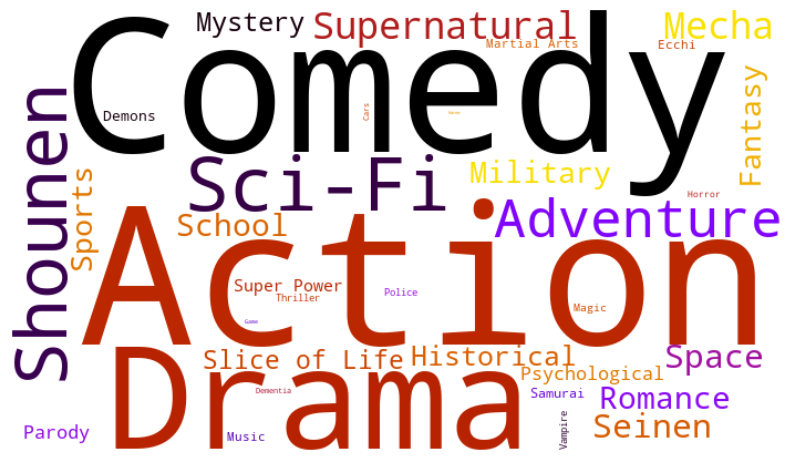

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [147]:
get_user_preferences(11880, rating_df, df, plot=True)

In [152]:
def get_user_recommendations(similar_users, user_pref, df, synopsis_df, rating_df,n =10 ):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id), rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i, anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name, str):
                    frame = getAnimeFrame(anime_name, df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id), synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis" : synopsis

                    })
    return pd.DataFrame(recommended_animes.head(n))



In [153]:
similar_users = find_similar_users(int(11880), user_weights, user2user_encoded, user2user_decoded)

Error Occurred 'similarity'


In [154]:
user_pref = get_user_preferences(11880, rating_df, df, plot = False)

In [1]:
get_user_recommendations(similar_users, user_pref, df, synopsis_df, rating_df, n=1)

NameError: name 'get_user_recommendations' is not defined

### Hybrid Recommender System

In [9]:
def hybrid_recommendation(user_id, user_weight=0.5, content_weight = 0.5):

    ## User Recommendation
    similar_users = find_similar_users(user_id, user_weights, user2user_encoded, user2user_decoded)
    user_pref = get_user_preferences(user_id, rating_df, df)
    user_recommended_animes = get_user_recommendations(similar_users, user_pref, df, synopsis_df, rating_df)

    user_recommended_anime_list = user_recommended_animes['anime_name'].to_list()

    ## Content Recommendation
    content_recommend_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes("Steins;Gate", anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)

        if similar_animes is not None and similar_animes.empty:
            content_recommend_animes.extend(similar_animes['name'].tolist())
        else:
            print(f" No similar anime found {anime}")

    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime, 0) + user_weight
    for anime in content_recommend_animes:
        combined_scores[anime] = combined_scores.get(anime, 0 ) + content_weight
    
    sorted_animes = sorted(combined_scores.items(), key=lambda x:x[1], reverse=True)

    return [anime for anime, score in sorted_animes[:10]]

        



In [10]:
hybrid_recommendation(11880)

NameError: name 'find_similar_users' is not defined